# Car Detection Dataset

Ref: https://public.roboflow.com/object-detection/self-driving-car/3

In [1]:
%%capture

!pip3 install numpy==1.17.4

import numpy as np
import pandas as pd 
from tqdm import tqdm

from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

!pip install fastai --upgrade

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision.all import *

In [3]:
!cat ./README.dataset.txt

# Udacity Self Driving Car > fixed-small
https://public.roboflow.ai/object-detection/self-driving-car

Provided by [Roboflow](https://roboflow.ai)
License: MIT

# Overview

The [original Udacity Self Driving Car Dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) is missing labels for thousands of pedestrians, bikers, cars, and traffic lights. This will result in poor model performance. When used in the context of self driving cars, this could even lead to human fatalities.

We re-labeled the dataset to correct errors and omissions. We have provided convenient downloads in many formats including VOC XML, COCO JSON, Tensorflow Object Detection TFRecords, and more.

Some examples of labels missing from the original dataset:
![Examples of Missing Labels](https://i.imgur.com/A5J3qSt.jpg)

# Stats

The dataset contains 97,942 labels across 11 classes and 15,000 images. There are 1,720 null examples (images with no labels).

All images are 1920x1200 (download size ~

In [4]:
!find ./export -type f | perl -ne 'print $1 if m/\.([^.\/]+)$/' | sort -u

jpg
json


In [5]:
!ls -R |grep "\.json$"

_annotations.coco.json


In [6]:
import json

with open('./export/_annotations.coco.json',) as f:
    annotations = json.load(f)
    
category_dict = {}
for cat in annotations['categories']:
    category_dict[cat['id']] = cat['name']
category_dict

{0: 'obstacles',
 1: 'biker',
 2: 'car',
 3: 'pedestrian',
 4: 'trafficLight',
 5: 'trafficLight-Green',
 6: 'trafficLight-GreenLeft',
 7: 'trafficLight-Red',
 8: 'trafficLight-RedLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft',
 11: 'truck'}

The follwoing is showing some random images from the dataset

In [7]:
!ls -U ./export | head -4

1478898182917339665_jpg.rf.V7nsqBMsWbh98nxQzjgn.jpg
1478895937750505958_jpg.rf.TDfYdTXa4SHAO9EkW57a.jpg
1478900673169695576_jpg.rf.Oe1Pn8ynmDrr9BGqs1Ue.jpg
1478732627767004210_jpg.rf.647c60adb47d621a7309e7fffd8e64c5.jpg
ls: write error: Broken pipe


uint8
(512, 512, 3)


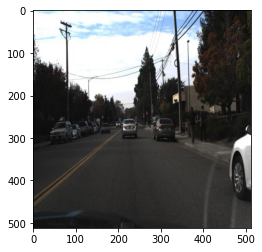

In [8]:
plt_image = image.imread('./export/1478897255713873932_jpg.rf.gboKysygWMebUx0uXVEx.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

plt.show()

uint8
(512, 512, 3)


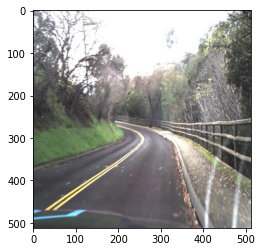

In [23]:
plt_image = image.imread('./export/1478900673169695576_jpg.rf.Oe1Pn8ynmDrr9BGqs1Ue.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

plt.show()

Dataloader to read the data from disk

In [10]:
class SelfDrivingCarDataset(torch.utils.data.Dataset):  
    def __init__(self, images_path, std=False):
        super(SelfDrivingCarDataset, self).__init__()
        self.images_path = glob.glob(images_path+"*jpg")
        self.std = std
        with open(images_path+'_annotations.coco.json',) as f:
            self.annotations = json.load(f)
        
    def __len__(self):
        return len(self.images_path)  

    def __getitem__(self, idx):
        file_path = self.images_path[idx]
        file_name = file_path.split("/")[2]
        img_id = None
        for img_name in self.annotations['images']:
            if img_name['file_name'] == file_name:
                img_id = img_name['id'] 
        
        bbox, areas, iscrowd, labels = [], [], [], []
        
        for box in self.annotations['annotations']:
            if box['image_id'] == img_id:
                bbox.append(box['bbox'])
                areas.append(box['area'])
                iscrowd.append(box['iscrowd'])
                labels.append(box['category_id'])
            
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        bbox = np.array(bbox)
        areas = np.array(areas)
        iscrowd = np.array(iscrowd)
        labels = np.array(labels)        
        
        if len(bbox) !=0:
            bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
            bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
            bbox = torch.from_numpy(bbox)
            bbox = torch.as_tensor(bbox, dtype=torch.int64)
        else:
            bbox = torch.zeros((0, 4), dtype=torch.float32)
            
        
        if self.std:
            img = img/255.0
            
        target = {}
        
        labels = torch.tensor(labels, dtype=torch.int64)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64) 
        image_id = torch.tensor([idx])
        areas = torch.as_tensor(areas.astype(np.float), dtype=torch.double)
        
        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id    
        
        img = np.array(img)
        if img.shape[0] != 3:
            img = img.reshape(3, img.shape[0], img.shape[1])
            
        img = torch.from_numpy(img)
        img = torch.as_tensor(img, dtype=torch.double)
        
        return img, target

The next show a sample image with the bounding boxes

torch.Size([512, 512, 3]) tensor([[243, 254, 248, 270],
        [235, 253, 240, 269],
        [131, 254, 164, 284],
        [190, 253, 225, 295],
        [348, 236, 429, 284]]) tensor([1, 1, 2, 2, 2])


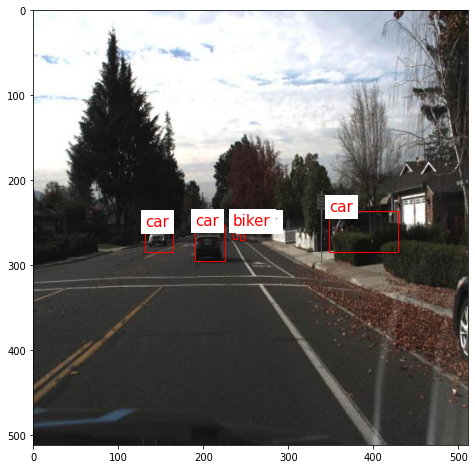

In [11]:
dataset = SelfDrivingCarDataset("./export/")

img, target = dataset.__getitem__(300)

img = img.reshape(img.shape[1], img.shape[2], 3)
img = torch.as_tensor(img, dtype=torch.int)
print(img.shape, target["boxes"], target["labels"])

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(img)
for lab, lab_name in zip(target['boxes'], target["labels"]):
    rect = patches.Rectangle((lab[0], lab[1]), lab[2]-lab[0], lab[3]-lab[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.annotate(category_dict[int(lab_name)],(lab[0], lab[1]), 
                color='red', fontsize=15,backgroundcolor="w")

    ax.add_patch(rect)

plt.show()

The next is used to train test split

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = SelfDrivingCarDataset("./export/", std=True)
val_dataset = SelfDrivingCarDataset("./export/", std=True)
test_dataset = SelfDrivingCarDataset("./export/", std=True)

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:18800])
val_dataset = torch.utils.data.Subset(val_dataset, indices[18800:23800])
test_dataset = torch.utils.data.Subset(test_dataset, indices[23800:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True, num_workers=0,
        collate_fn = collate_fn)

val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=4, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

In [13]:
print('Size of train data: ',len(train_dataset))
print('Size of val data: ',len(val_dataset))
print('Size of test data: ',len(test_dataset))

Size of train data:  18800
Size of val data:  5000
Size of test data:  6000


In [14]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device:", device)

Device: cuda Tesla P100-PCIE-16GB


The followin packages are used in the training of the RCNN

In [19]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .


output/vision already cloned


In [20]:
%%capture
!pip3 install pycocotools
!pip3 install -U scikit-image
!pip3 install -U cython 

Here we use fasterRCNN with mobilenet with number of classes is 13 which is (classes + background)

In [16]:
import torchvision
num_classes = 13  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
fasterRCNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features
fasterRCNN_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [17]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
from engine import train_one_epoch, evaluate
import time

loss_hist = LossAverager()

EPOCHS = 2

fasterRCNN_model.double()
fasterRCNN_model.to(device)

params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    tick = time.time()
    fasterRCNN_model.train()
    loss_hist.reset()
    
    for images, targets in tqdm(train_dataloader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]    
        loss_dict = fasterRCNN_model(images, targets)
    
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue, bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
        lr_scheduler.step(totalLoss)
        
    print(f"Train loss: {loss_hist.avg}")
    loss_hist.reset()
    
    for images, targets in val_dataloader:
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = fasterRCNN_model(images, targets)
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        loss_hist.update(lossValue,bs)
        
    print(f"Val loss: {loss_hist.avg}")

Epoch 1/2


  0%|          | 0/4700 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding

Train loss: 0.6465289183609638
Val loss: 0.6938453152739976
Epoch 2/2


100%|██████████| 4700/4700 [2:13:23<00:00,  1.70s/it]  


Train loss: 0.6758536801224156
Val loss: 0.700689762989191


The training was stopped at 2 epochs as the training time is 2h13m for each epoch

In [24]:
fasterRCNN_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
def sample_prediction():
    fasterRCNN_model.eval()
    cpu = torch.device("cpu")
    fasterRCNN_model.to(cpu)
    sample_image = test_dataset.__getitem__(200)[0]
    groundtruth_boxes = test_dataset.__getitem__(200)[1]["boxes"]
    sample_image = torch.unsqueeze(sample_image, 0)
    sample_image.to(cpu)
    outputs = fasterRCNN_model(sample_image)
    outputs = [{k: v for k, v in t.items()} for t in outputs]
    boxes = outputs[0]["boxes"].detach().numpy()
    scores = outputs[0]["scores"].detach().numpy()
    labels = outputs[0]["labels"].detach().numpy()
    sample_image = sample_image.reshape(
        sample_image.shape[2],sample_image.shape[3], 3)
    return sample_image, boxes, scores, labels, groundtruth_boxes

sample_image, boxes, scores, labels, groundtruth_boxes = sample_prediction()

We apply non maximum suppression to elliminate the lower scorng boxes that have high IOU scores with another box

In [37]:
def nms():
    """NMS iteratively removes lower scoring boxes which have an IoU 
    greater than iou_threshold with another (higher scoring) box.
    """
    iou = 0.99
    iou_threshold = 1 - iou
    NMS = torchvision.ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    best_boxes, best_scores, best_labels = [], [], []
    for nms in NMS:
        best_boxes.append(boxes[nms])
        best_scores.append(scores[nms])
        best_labels.append(labels[nms])
    return best_boxes, best_scores, best_labels

best_boxes, best_scores, best_labels = nms()

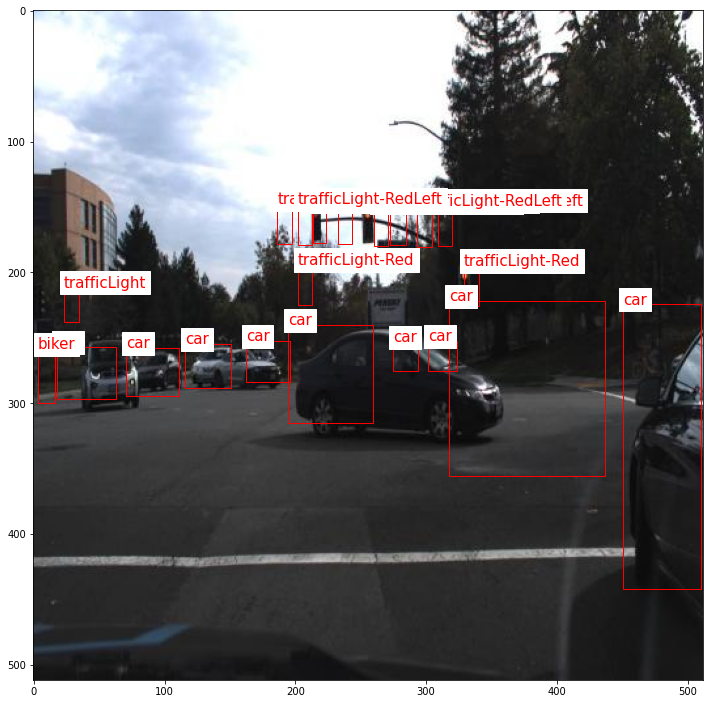

In [38]:
fig, ax = plt.subplots(figsize=(12,18))
ax.imshow(sample_image)
for box, score, label in zip(best_boxes, best_scores, best_labels):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.annotate(category_dict[label],(box[0], box[1]), color='red', fontsize=15,backgroundcolor="w")
    ax.add_patch(rect)
plt.show()